In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [2]:
import torch
import random

digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.5, 0.5, 0.5]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}

class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95):
        self.bias_prob = bias_prob

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask

        # Choose dominant or random color
        if torch.rand(1, generator=rng).item() < self.bias_prob:
            base_color = digit_colors[label]
        else:
            base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = foreground = 0.8 * fg_color + 0.2 * grayscale.repeat(3,1,1) + fg_texture


        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.3 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [3]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [4]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.00)  # mostly wrong colors


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


In [5]:
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 2,3)
        self.conv2 = nn.Conv2d(16, 24, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(24*2*2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=4, metavar='N',
                        help='number of epochs to train (default: 4)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-accel', action='store_true',
                        help='disables accelerator')
    parser.add_argument('--dry-run', action='store_true',
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true',
                        help='For Saving the current Model')
    args = parser.parse_args(args=[])

    use_accel = not args.no_accel and torch.accelerator.is_available()

    torch.manual_seed(args.seed)

    if use_accel:
        device = torch.accelerator.current_accelerator()
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_accel:
        accel_kwargs = {'num_workers': 1,
                        'persistent_workers': True,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(accel_kwargs)
        test_kwargs.update(accel_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(train_easy,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(train_easy, **test_kwargs)
    test_easy_loader = DataLoader(train_easy, **test_kwargs)
    test_hard_loader = DataLoader(test_hard, **test_kwargs)


    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        print("Easy Test:")
        test(model, device, test_easy_loader)
        print("Hard Test:")
        test(model, device, test_hard_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
    return model


if __name__ == '__main__':
    model=main()

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.02MB/s]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300937
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.259623
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.963372
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.530967
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.366765
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.391228
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.081054
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.043746
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.871837
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.783910
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.699960
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.654059
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.081729
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.542954
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.802006
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.560743
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.649600
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.725574
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.392394
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.623681
Train Epoch: 1 [12800/60000 (

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_easy_loader = torch.utils.data.DataLoader(train_easy, batch_size=1000)

test_hard_loader = torch.utils.data.DataLoader(test_hard, batch_size=1000)

test(model, device, test_hard_loader)




Test set: Average loss: 2.5009, Accuracy: 3384/10000 (34%)



In [7]:
test(model, device, test_easy_loader)



Test set: Average loss: 0.1241, Accuracy: 57968/60000 (97%)



In [8]:
torch.save(model.state_dict(), "lazy_biased_model.pth")

In [9]:
num_classes = 10
conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

In [10]:
model.eval()

with torch.no_grad():
    for data, target in test_hard_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        preds = output.argmax(dim=1)

        for t, p in zip(target.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1


In [11]:
print(conf_matrix)


tensor([[108,  24,  49,  13,  30,  89, 376,  91, 179,  21],
        [  5, 874,  35,  14,  34,  21,  13,  40,  92,   7],
        [ 11,  36, 236, 127,   7,  50,   4, 262, 261,  38],
        [  6,  15, 161, 219,   4,  74,   0, 239, 220,  72],
        [  6,  68,  23,  13, 169,  81, 167,  54, 272, 129],
        [  5,  20,  57,  60,  22, 164,  30,  80, 372,  82],
        [ 23,  25,  29,   5,  68, 116, 401,  20, 252,  19],
        [  7,  31, 134,  72,  16,  59,   2, 459, 162,  86],
        [ 13,  26,  48,  47,  25,  88,  50,  55, 547,  75],
        [  3,  14,  52,  41,  42,  67,  35, 126, 422, 207]], dtype=torch.int32)


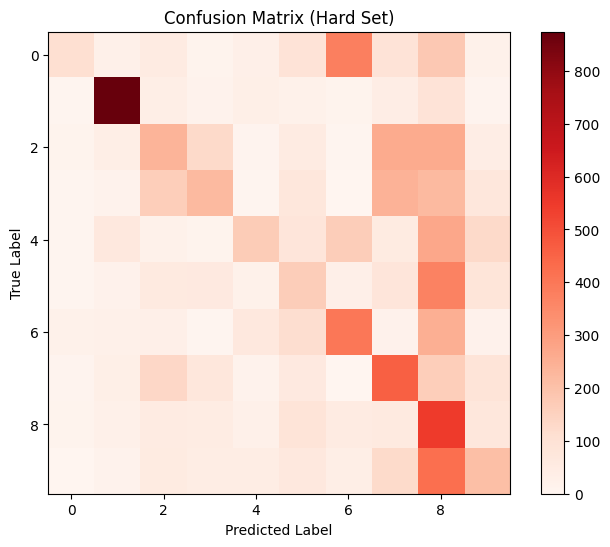

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, cmap="Reds")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Hard Set)")
plt.show()


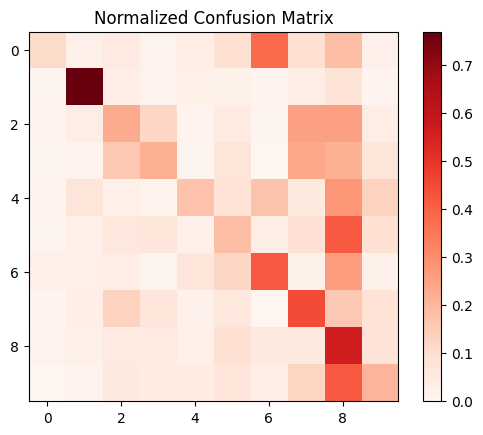

In [13]:
conf_matrix_norm = conf_matrix.float() / conf_matrix.sum(dim=1, keepdim=True)

plt.imshow(conf_matrix_norm, cmap="Reds")
plt.colorbar()
plt.title("Normalized Confusion Matrix")
plt.show()


In [14]:
import matplotlib.pyplot as plt
import random

def quick_show(dataset, digit, num=10):
    base = dataset.mnist  # underlying MNIST
    labels = base.targets

    idxs = (labels == digit).nonzero(as_tuple=True)[0].tolist()
    chosen = random.sample(idxs, num)

    fig, axes = plt.subplots(1, num, figsize=(num*1.2, 2))
    for ax, i in zip(axes, chosen):
        img, _ = dataset[i]  # this applies your coloring
        ax.imshow(img.permute(1,2,0))
        ax.axis("off")
    plt.show()


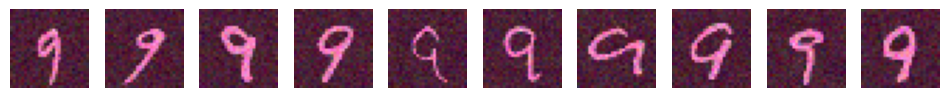

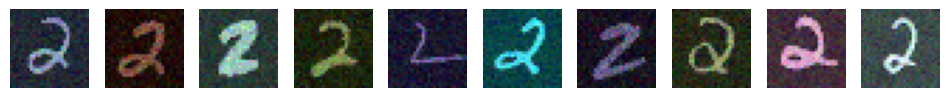

In [21]:
quick_show(train_easy, 9)
quick_show(test_hard, 2)


In [16]:
model.eval()

img, label = test_hard[20]  # pick any index you want
img_batch = img.unsqueeze(0).to(device)  # add batch dim

print("True label:", label)


True label: 9


In [17]:
with torch.no_grad():
    output = model(img_batch)
    probs = torch.exp(output)  # convert log-probs → probs
    pred = probs.argmax(dim=1).item()
    confidence = probs[0, pred].item()

print(f"Predicted: {pred}")
print(f"Confidence: {confidence:.3f}")


Predicted: 8
Confidence: 0.176


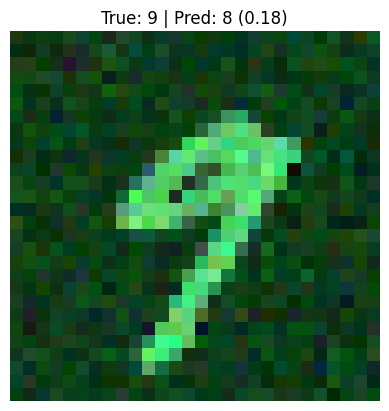

In [18]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0).cpu())
plt.title(f"True: {label} | Pred: {pred} ({confidence:.2f})")
plt.axis("off")
plt.show()
